#### **Import Required Libraries**

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from econml.dml import LinearDML


#### **Load Diabetes Data**
- The Behavioral Risk Factor Surveillance System (BRFSS) is a healthrelated telephone survey that is collected annually by the CDC,
- It is a refined dataset containing 253,680 survey responses to the CDC's BRFSS2015
- Link to the data: [Kaggle Dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv)

In [3]:
diabetes_df = pd.read_csv('diabetes_brfss2015.csv')
diabetes_df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
print("Shape of the dataset:", diabetes_df.shape)

Shape of the dataset: (253680, 22)


#### **Causal Model**

In [5]:
# Convert outcome to binary: 1 if diabetes/pre-diabetes, else 0
outcome = "Diabetes_012" 
diabetes_df[outcome] = diabetes_df[outcome].apply(lambda x: 1 if x > 0 else 0)

treatment = "PhysActivity" # whether the person exercises
covars = [
"Age", "Sex", "Education", "Income",
"HighBP", "HighChol", "BMI", "Smoker",
"HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost",
"Stroke", "HeartDiseaseorAttack", "DiffWalk"
]

In [6]:
# prepare the data
Y = diabetes_df[outcome].to_numpy(float)
T = diabetes_df[treatment].to_numpy(int)
X = diabetes_df[covars].to_numpy(float)

# define models for outcome and treatment
model_y = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, random_state=42)
model_t = LogisticRegression(max_iter=2000)

In [7]:
# linear DML model
dml = LinearDML(
model_y=model_y,
model_t=model_t,
discrete_treatment=True,
random_state=42
)

# fit the model
dml.fit(Y, T, X=X)

In [8]:
# CATE and ATE estimation

# Individual-level (CATE)
cate_dml = dml.effect(X)

# Average Treatment Effect (ATE)
ate_dml = float(np.mean(cate_dml))
print("LinearDML ATE (mean CATE):", round(ate_dml, 3))

LinearDML ATE (mean CATE): -0.016


Results:
- The mean CATE value shows that engaging in physical activity reduces the probability of diabetes by ~1.6 percentage, after adjusting for age, BMI
- The effect is relatively small.

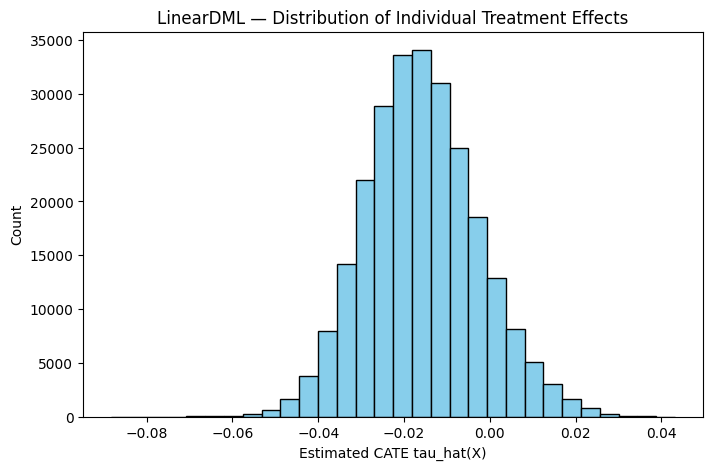

In [9]:
# visualize the distribution of CATEs
plt.figure(figsize=(8,5))
plt.hist(cate_dml, bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Estimated CATE tau_hat(X)")
plt.ylabel("Count")
plt.title("LinearDML — Distribution of Individual Treatment Effects")
plt.show()

In [10]:
# sub group analysis by age to see if treatment effect varies by age
age_groups = pd.cut(diabetes_df["Age"], bins=[0,3,6,9,13], labels=["18–24","25–34","35–44","45+"])
subgroup_effects = []

for group in age_groups.unique():
    mask = age_groups == group
    subgroup_effects.append((group, np.mean(cate_dml[mask])))

print(subgroup_effects)

[('35–44', np.float64(-0.01670995334767021)), ('45+', np.float64(-0.024651133159277413)), ('25–34', np.float64(-0.007855037288713472)), ('18–24', np.float64(0.003489665306681997))]


Sub group analysis results: 
- Age (18 -24) : 0.003 shows no effect
- Age (25-34) : -0.007 shows small effect
- Age (35-44) : -0.016 good effect
- Age (45+) : -0.024 shows strongest effect

Overall, physical activity helps most as people age, where diabetes risk is higher.